In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_curve, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
import xgboost


In [2]:
#load our data
hearty = pd.read_csv("heart-disease.csv")
hearty.head(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1


In [3]:
hearty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [4]:
import seaborn as sns

In [5]:
hearty.sex.value_counts()

1    207
0     96
Name: sex, dtype: int64

In [6]:
hearty.cp[hearty["sex"]==1].head(2)

0    3
1    2
Name: cp, dtype: int64

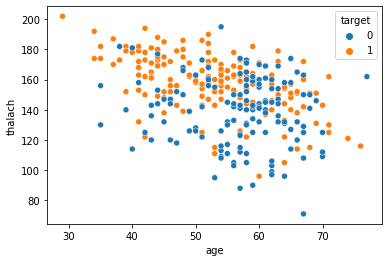

In [7]:
sns.scatterplot(x = hearty.age,y=hearty.thalach,hue=hearty.target,legend=True);

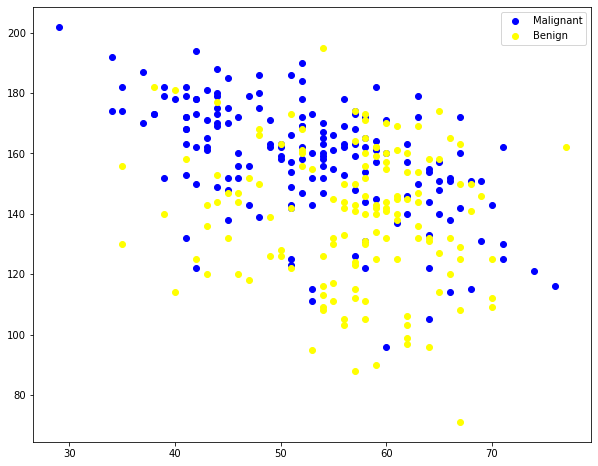

In [25]:
#view some beautiful looking data
fig, ax = plt.subplots(figsize=[10,8])
ax.scatter(hearty.age[hearty["target"]==1],hearty.thalach[hearty["target"]==1],color="blue",label="Malignant")
ax.scatter(hearty.age[hearty["target"]==0],hearty.thalach[hearty["target"]==0],color="yellow",label="Benign")
plt.legend();

In [8]:
np.random.seed(42)

X = hearty.drop("target",axis=1)
y = hearty["target"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

model = xgboost.XGBClassifier(use_label_encoder=False)
model.fit(X_train,y_train)
model.score(X_train,y_train)

[20:27:21] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


1.0

In [9]:
y_predo = model.predict(X_test)
accuracy_score(y_test,y_predo)

0.819672131147541

In [30]:
model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [10]:
print(classification_report(y_test,y_predo))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        29
           1       0.86      0.78      0.82        32

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61



In [13]:
model.feature_importances_[0]

0.03591879

In [14]:
dicty = dict(zip(X.columns,model.feature_importances_))
dicty

{'age': 0.03591879,
 'sex': 0.059084557,
 'cp': 0.19068019,
 'trestbps': 0.036347207,
 'chol': 0.03393608,
 'fbs': 0.029837945,
 'restecg': 0.026837952,
 'thalach': 0.029591804,
 'exang': 0.16715042,
 'oldpeak': 0.08929924,
 'slope': 0.055949654,
 'ca': 0.13838223,
 'thal': 0.106983915}

In [16]:
dicty_df = pd.DataFrame(dicty,index=[0])
dicty_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0.035919,0.059085,0.19068,0.036347,0.033936,0.029838,0.026838,0.029592,0.16715,0.089299,0.05595,0.138382,0.106984


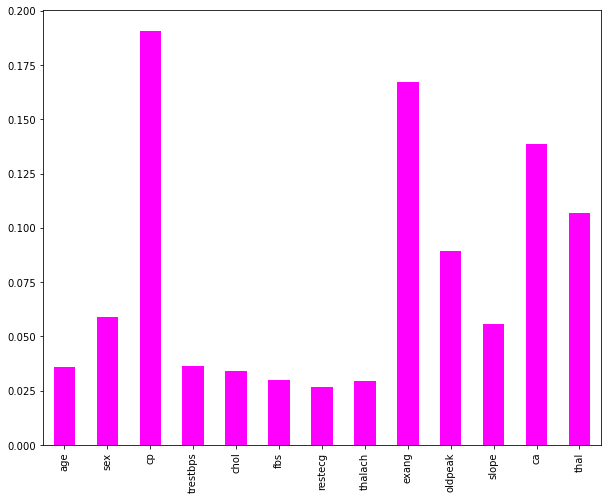

In [18]:
dicty_df.T.plot(kind="bar",figsize=[10,8],legend=False,color="magenta");

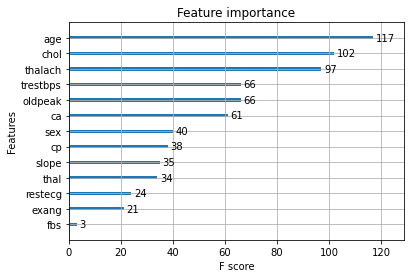

In [19]:
xgboost.plot_importance(model);

In [20]:
from sklearn.feature_selection import SelectFromModel

In [28]:
X_train_sel.shape[1]

1

In [29]:
thresholds = np.sort(model.feature_importances_)
for thre in thresholds:
    selection = SelectFromModel(model,threshold=thre,prefit=True)
    X_train_sel = selection.transform(X_train)
    mod = xgboost.XGBClassifier(use_label_encoder=False,eval_metric="logloss")
    mod.fit(X_train_sel,y_train)
    X_test_sel = selection.transform(X_test)
    y_predy = mod.predict(X_test_sel)
    accuracy = accuracy_score(y_test,y_predy)
    print("threshold:{}, n:{}, accuracy:{:.2f}".format(thre,X_train_sel.shape[1],accuracy*100))

threshold:0.026837952435016632, n:13, accuracy:81.97
threshold:0.02959180437028408, n:12, accuracy:81.97
threshold:0.029837945476174355, n:11, accuracy:83.61
threshold:0.03393607959151268, n:10, accuracy:81.97
threshold:0.035918790847063065, n:9, accuracy:80.33
threshold:0.03634720668196678, n:8, accuracy:80.33
threshold:0.055949654430150986, n:7, accuracy:81.97
threshold:0.05908455699682236, n:6, accuracy:78.69
threshold:0.08929923921823502, n:5, accuracy:83.61
threshold:0.10698391497135162, n:4, accuracy:83.61
threshold:0.138382226228714, n:3, accuracy:80.33
threshold:0.16715042293071747, n:2, accuracy:73.77
threshold:0.19068019092082977, n:1, accuracy:83.61
